In [13]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
# Hyperparameters
HEIGHT = 368
WIDTH  = 368

## Pre processing

In the pre-processing stage we only apply two transformations:

- Reduce size of image to HEIGHT, WIDTH
- Transform the image to pytorch tensor

We then store the tensors in new folders:'train_images_xx' and 'train_masks_xx' (you need to create those folders beforehand). The rest of transformations happen in the DataLoader. The reason is that size is constant for all images, therefore, we can apply to all images without exceptions. Similarly we can transfer all images to tensors because we do it for **all** images. Other transformations are applied randomly each time DataLoader outputs a batch (so same batch in 2 different epochs can have different transformations), therefore, we cannot include them in pre-process stage.

In [86]:
import os
path_train = 'data/Train'
list_train_img = []
list_im_rur = sorted(os.listdir(f'{path_train}/Rural/images_png'))

for i in list_im_rur:
    list_train_img.append(f'{path_train}/Rural/images_png/{i}')
    
list_im_urb = sorted(os.listdir(f'{path_train}/Urban/images_png'))
for i in list_im_urb:
    list_train_img.append(f'{path_train}/Urban/images_png/{i}')

list_train_img = sorted(list_train_img)

list_train_masks = []
list_msk_rur = sorted(os.listdir(f'{path_train}/Rural/masks_png'))

for i in list_msk_rur:
    list_train_masks.append(f'{path_train}/Rural/masks_png/{i}')
    
list_msk_urb = sorted(os.listdir(f'{path_train}/Urban/masks_png'))
for i in list_msk_urb:
    list_train_masks.append(f'{path_train}/Urban/masks_png/{i}')

list_train_masks = sorted(list_train_masks)




In [87]:
path_val = 'data/Val'
list_val_img = []
list_im_rur = sorted(os.listdir(f'{path_val}/Rural/images_png'))

for i in list_im_rur:
    list_val_img.append(f'{path_val}/Rural/images_png/{i}')
    
list_im_urb = sorted(os.listdir(f'{path_val}/Urban/images_png'))
for i in list_im_urb:
    list_val_img.append(f'{path_val}/Urban/images_png/{i}')

list_val_img = sorted(list_val_img)

list_val_masks = []
list_msk_rur = sorted(os.listdir(f'{path_val}/Rural/masks_png'))

for i in list_msk_rur:
    list_val_masks.append(f'{path_val}/Rural/masks_png/{i}')
    
list_msk_urb = sorted(os.listdir(f'{path_val}/Urban/masks_png'))
for i in list_msk_urb:
    list_val_masks.append(f'{path_val}/Urban/masks_png/{i}')

list_val_masks = sorted(list_val_masks)

In [18]:
import os
path_test = 'data/ramenki/'
list_test_img = []
list_im_test = sorted(os.listdir(f'{path_test}'))
for i in list_im_test:
    list_test_img.append(f'{path_test}{i}')

list_test_img = sorted(list_test_img)
list_test_img

['data/ramenki/1.tif',
 'data/ramenki/10.tif',
 'data/ramenki/11.tif',
 'data/ramenki/12.tif',
 'data/ramenki/13.tif',
 'data/ramenki/14.tif',
 'data/ramenki/15.tif',
 'data/ramenki/16.tif',
 'data/ramenki/17.tif',
 'data/ramenki/18.tif',
 'data/ramenki/19.tif',
 'data/ramenki/2.tif',
 'data/ramenki/20.tif',
 'data/ramenki/21.tif',
 'data/ramenki/22.tif',
 'data/ramenki/23.tif',
 'data/ramenki/24.tif',
 'data/ramenki/3.tif',
 'data/ramenki/4.tif',
 'data/ramenki/5.tif',
 'data/ramenki/6.tif',
 'data/ramenki/7.tif',
 'data/ramenki/8.tif',
 'data/ramenki/9.tif']

In [91]:
import pandas as pd
train_df = pd.DataFrame(list_train_img, columns = ['Images'])
train_df['Masks'] = list_train_masks
train_df

,Images,Masks
0,data/Train/Rural/images_png/0.png,data/Train/Rural/masks_png/0.png
1,data/Train/Rural/images_png/1.png,data/Train/Rural/masks_png/1.png
2,data/Train/Rural/images_png/10.png,data/Train/Rural/masks_png/10.png
3,data/Train/Rural/images_png/100.png,data/Train/Rural/masks_png/100.png
4,data/Train/Rural/images_png/1000.png,data/Train/Rural/masks_png/1000.png
...,...,...
2517,data/Train/Urban/images_png/2517.png,data/Train/Urban/masks_png/2517.png
2518,data/Train/Urban/images_png/2518.png,data/Train/Urban/masks_png/2518.png
2519,data/Train/Urban/images_png/2519.png,data/Train/Urban/masks_png/2519.png
2520,data/Train/Urban/images_png/2520.png,data/Train/Urban/masks_png/2520.png


In [92]:

val_df = pd.DataFrame(list_val_img, columns = ['Images'])
val_df['Masks'] = list_val_masks
val_df

,Images,Masks
0,data/Val/Rural/images_png/2522.png,data/Val/Rural/masks_png/2522.png
1,data/Val/Rural/images_png/2523.png,data/Val/Rural/masks_png/2523.png
2,data/Val/Rural/images_png/2524.png,data/Val/Rural/masks_png/2524.png
3,data/Val/Rural/images_png/2525.png,data/Val/Rural/masks_png/2525.png
4,data/Val/Rural/images_png/2526.png,data/Val/Rural/masks_png/2526.png
...,...,...
1664,data/Val/Urban/images_png/4186.png,data/Val/Urban/masks_png/4186.png
1665,data/Val/Urban/images_png/4187.png,data/Val/Urban/masks_png/4187.png
1666,data/Val/Urban/images_png/4188.png,data/Val/Urban/masks_png/4188.png
1667,data/Val/Urban/images_png/4189.png,data/Val/Urban/masks_png/4189.png


In [15]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
#root = os.getcwd()
import os
path_img = 'data/train_images'
path_mask = 'data/train_masks'
train_img_link_list  = sorted(os.listdir(path_img))
train_mask_link_list = sorted(os.listdir(path_mask))
#test_img_link_list   = sorted(glob.glob('/data/test_images/*'))

In [95]:


# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(train_df.shape[0])):
    
    img_id  = train_df['Images'][i].split('/')[-1].split('.')[0]
    mask_id = train_df['Masks'][i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match
    
    img   = Image.open(train_df['Images'][i])
    mask  = Image.open(train_df['Masks'][i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()
    
    torch.save(img, f'data/new_train_images_{HEIGHT}/{img_id}.pt')
    torch.save(mask, f'data/new_train_masks_{HEIGHT}/{mask_id}.pt')
    
print('Train set created')

for i in tqdm(range(val_df.shape[0])):
    
    img_id  = val_df['Images'][i].split('/')[-1].split('.')[0]
    mask_id = val_df['Masks'][i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match
    
    img   = Image.open(val_df['Images'][i])
    mask  = Image.open(val_df['Masks'][i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()
    
    torch.save(img, f'data/new_val_images_{HEIGHT}/{img_id}.pt')
    torch.save(mask, f'data/new_val_masks_{HEIGHT}/{mask_id}.pt')
    
print('Val set created')

## Iterate through all images in test set, transform them and store corresponging tensors in a new folder
#for i in tqdm(range(len(test_img_link_list))):
#    
#    img_id  = test_img_link_list[i].split('/')[-1].split('.')[0]
#    
#    img   = Image.open(test_img_link_list[i])
#    img   = transform_img(img)
#    torch.save(img, f'data/test_images_{HEIGHT}/{img_id}.pt')
    
    
#print('Test set created')
    

100%|██████████████████████████████████████████████████████████████████████████████| 2522/2522 [02:01<00:00, 20.79it/s]


Train set created


100%|██████████████████████████████████████████████████████████████████████████████| 1669/1669 [01:20<00:00, 20.82it/s]

Val set created


In [21]:
from PIL import Image

def convert_tiff_to_jpg_or_png(input_file, output_file, format):
    image = Image.open(input_file)
    image.save(output_file, format=format)

for i in tqdm(range(len(list_test_img))):
    img_id  = list_test_img[i].split('/')[-1].split('.')[0]
    convert_tiff_to_jpg_or_png(list_test_img[i], f'data/test_368_png/{img_id}.png', 'PNG')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:56<00:00,  2.33s/it]


In [22]:
path_test = 'data/test_368_png/'
list_test_img = []
list_im_test = sorted(os.listdir(f'{path_test}'))
for i in list_im_test:
    list_test_img.append(f'{path_test}{i}')

list_test_img = sorted(list_test_img)
list_test_img

['data/test_368_png/1.png',
 'data/test_368_png/10.png',
 'data/test_368_png/11.png',
 'data/test_368_png/12.png',
 'data/test_368_png/13.png',
 'data/test_368_png/14.png',
 'data/test_368_png/15.png',
 'data/test_368_png/16.png',
 'data/test_368_png/17.png',
 'data/test_368_png/18.png',
 'data/test_368_png/19.png',
 'data/test_368_png/2.png',
 'data/test_368_png/20.png',
 'data/test_368_png/21.png',
 'data/test_368_png/22.png',
 'data/test_368_png/23.png',
 'data/test_368_png/24.png',
 'data/test_368_png/3.png',
 'data/test_368_png/4.png',
 'data/test_368_png/5.png',
 'data/test_368_png/6.png',
 'data/test_368_png/7.png',
 'data/test_368_png/8.png',
 'data/test_368_png/9.png']

In [26]:


# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(list_test_img))):
    
    
    img_id  = list_test_img[i].split('/')[-1].split('.')[0]
    
    img   = Image.open(list_test_img[i])
    img = img.convert('RGB')

    img  = transform_img(img)
    
    torch.save(img, f'data/test_{HEIGHT}/{img_id}.pt')
    
print('Test set created')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.54it/s]

Test set created


## Overview of additional samples

In [3]:
img_tensors_links  = sorted(os.listdir(f'data/new_train_images_{HEIGHT}'))
mask_tensors_links = sorted(os.listdir(f'data/new_train_masks_{HEIGHT}'))
img_tensors_links  = img_tensors_links[-31:]
mask_tensors_links = mask_tensors_links[-31:]

In [4]:
def show_random_images(i, img_links, mask_links):
    
    img = torch.load(f'data/new_train_images_{HEIGHT}/{img_links[i]}')
    mask = torch.load(f'data/new_train_masks_{HEIGHT}/{mask_links[i]}')
    
    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(mask.permute(1,2,0).detach().numpy())
    plt.show()

In [27]:
img = torch.load(f'data/test_{HEIGHT}/1.pt')

In [28]:
img.shape

torch.Size([3, 368, 368])

In [12]:
for i in range(200):
    mask = torch.load(f'data/new_train_masks_{HEIGHT}/{mask_tensors_links[i]}')
    print(torch.unique(mask))

tensor([1, 2, 4, 6], dtype=torch.int32)
tensor([1, 2, 4, 6], dtype=torch.int32)
tensor([1, 3, 4, 6, 7], dtype=torch.int32)
tensor([1, 2, 6], dtype=torch.int32)
tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
tensor([1, 3, 4, 6], dtype=torch.int32)
tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
tensor([1, 2], dtype=torch.int32)
tensor([1, 2, 3, 4, 6, 7], dtype=torch.int32)
tensor([1, 6, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 6, 7], dtype=torch.int32)
tensor([1, 2, 4, 6, 7], dtype=torch.int32)
tensor([0, 1, 2, 3, 4, 5, 7], dtype=torch.int32)
tensor([1, 4, 6, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
tensor([1, 2, 4, 7], dtype=torch.int32)
tensor([1, 3, 4, 6, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 6, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 7], dtype=torch.int32)
tensor([1, 2, 3, 4, 7], dtype=torch.int32)
tensor([

IndexError: list index out of range

In [11]:
torch.unique(mask)

tensor([1, 2, 3, 4, 6, 7], dtype=torch.int32)

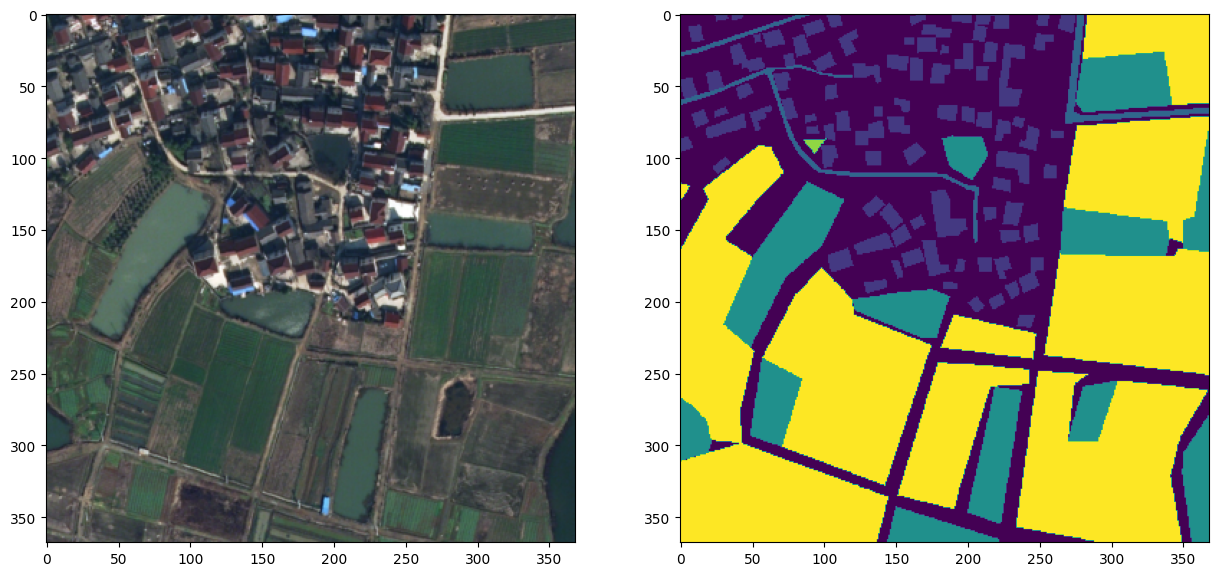

In [7]:
show_random_images(25, img_tensors_links, mask_tensors_links)

In [36]:
# Delete images that capture just a small fraction of the desired object
to_del = [5,11,12,13]
for item in to_del:
    os.remove(f'data/train_images_{HEIGHT}/{img_tensors_links[item]}')
    os.remove(f'data/train_masks_{HEIGHT}/{mask_tensors_links[item]}')

In [ ]:
m